## Preprocessing


### Read files - assign labels - encode labels

In [2]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Directory where the data files are stored
data_folder = '../data'

def read_file(file_path):
    # Open and read the data from a file
    with open(file_path, 'r') as file:
         data_str = file.read()
    # Remove brackets and commas, then convert text to a list of floats
    data_str_filtered = data_str.translate(str.maketrans('', '', '[],'))
    data_list = [float(item) for item in data_str_filtered.split() if item]
    # Convert the list to a NumPy array and reshape it
    data_array = np.array(data_list)
    reshaped_data = np.array(data_array.reshape(140, 61, 1))
    return reshaped_data

def assign_label(file_name):
    # Assign labels based on the file name
    if 'bottle' in file_name: return 'Bottle'
    elif 'cap' in file_name: return 'Cap'
    elif 'mug' in file_name: return 'Mug' 
    elif 'wall' in file_name: return 'Wall'
    else: return 'Unknown'

# List to store data along with their labels
data_labels = []
# Collect all data for normalization
all_data = []

### Read and preprocess each file in the data directory
for file_name in os.listdir(data_folder):
    file_path = os.path.join(data_folder, file_name)
    
    # Check if the file name is "shoe1.txt" and skip it
    if 'wall' in file_name:
        continue
    
    if os.path.isfile(file_path):
        # Read and preprocess the data file
        content = read_file(file_path)
        # Collect data for finding the global maximum value
        all_data.append(content)
        # Assign label based on the file name
        label = assign_label(file_name)
        # Append the preprocessed data and its label to the list
        data_labels.append((content, label))

### Normalize the data
# First, concatenate all data to find the global maximum
all_data_np = np.concatenate(all_data, axis=0)
# Find the maximum value across all data for normalization
global_max = np.max(all_data_np)

# Normalize each piece of data by the global maximum
normalized_data_labels = [(content/global_max, label) for content, label in data_labels]

# Split the normalized data and labels for training and testing
X, y = zip(*data_labels)
# Initialize and fit the label encoder to convert labels into integers
label_encoder = LabelEncoder()
y_integers = label_encoder.fit_transform(y)
y_encoded = to_categorical(y_integers)

# Shuffle the data and labels together to maintain correspondence
X_shuffled, y_shuffled = shuffle(X, y_encoded, random_state=42)### Split the dataset into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.25, random_state=42)

# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Print the sizes of the training and test sets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)


Shape of X_train:  (225, 140, 61, 1)
Shape of y_train:  (225, 3)
Shape of X_test:  (75, 140, 61, 1)
Shape of y_test:  (75, 3)


## Vizualization

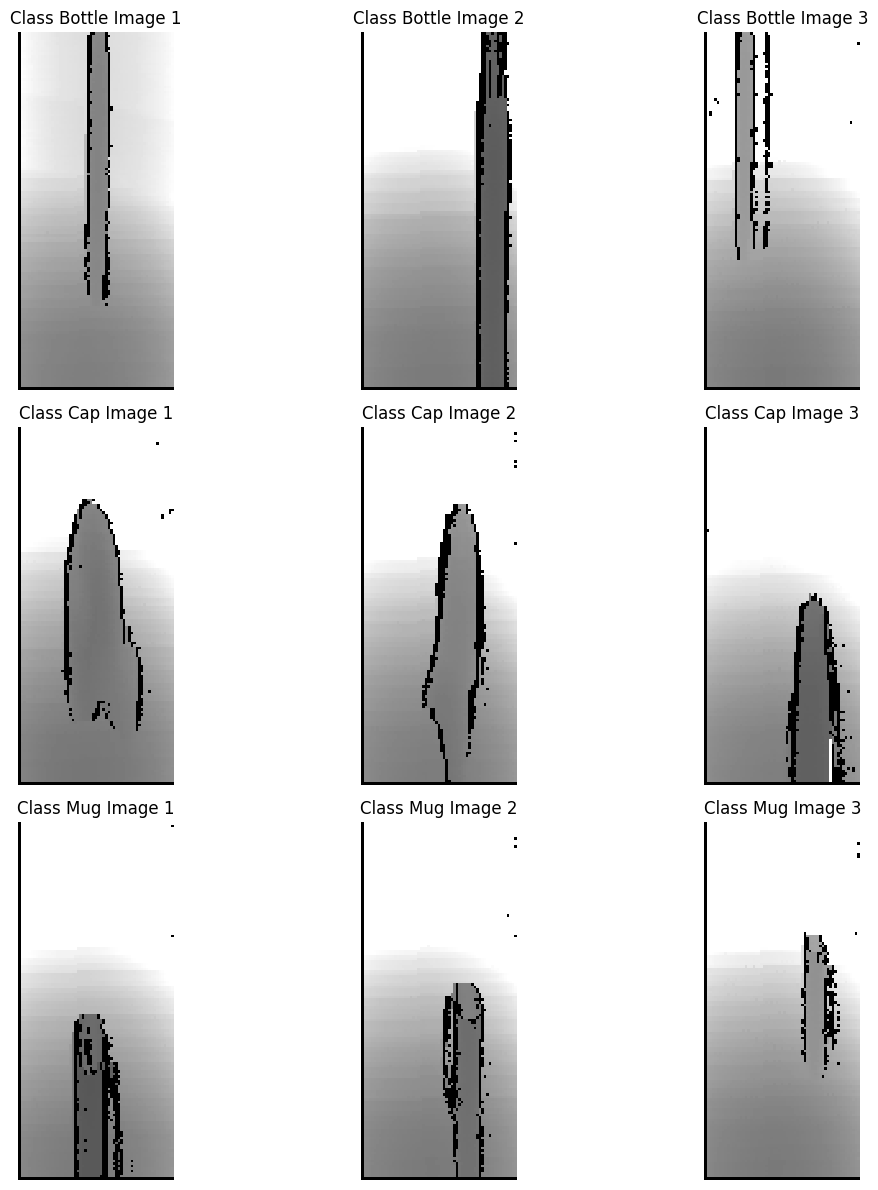

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'X' is your images array and 'y_encoded' are your numerically encoded labels
unique_classes = np.unique(y_integers)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # Set up a 3x3 grid
axes = axes.flatten()  # Flatten the axes array for easier use

for i, cls in enumerate(unique_classes):
    cls_indices = np.where(y_integers == cls)[0][:3]  # Get first 3 indices of each class
    for j, idx in enumerate(cls_indices):
        if i*3+j >= 9:  # Stop after filling the 3x3 grid
            break
        image = X[idx]  # Replace this with actual image fetching logic
        # Preprocess the image as needed
        clipped_array = np.clip(image, None, 1000)
        flipped_array = np.flipud(clipped_array)

        axes[i*3+j].imshow(flipped_array, cmap='gray', interpolation='nearest')
        axes[i*3+j].set_title(f'Class {label_encoder.inverse_transform([cls])[0]} Image {j+1}')
        axes[i*3+j].axis('off')  # Hide axis ticks

plt.tight_layout()
plt.show()

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def get_model():
    
    height = 140
    width = 61

    model = Sequential([
        Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(height, width, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')  # Three classes for classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

#fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)
model_simple = get_model()
model_simple.summary()

c:\Users\berkb\anaconda3\envs\keras_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 140, 61, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 70, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 70, 30, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │     1,075,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,080,259 (4.12 MB)

 Trainable params: 1,080,259 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model_simple.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.3346 - loss: 797.2156 - val_accuracy: 0.4400 - val_loss: 59.4265
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4246 - loss: 25.5078 - val_accuracy: 0.4000 - val_loss: 4.2698
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4862 - loss: 1.3265 - val_accuracy: 0.4267 - val_loss: 1.2199
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5586 - loss: 0.8938 - val_accuracy: 0.4800 - val_loss: 1.8088
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6525 - loss: 0.6699 - val_accuracy: 0.7867 - val_loss: 2.3302
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7337 - loss: 0.9034 - val_accuracy: 0.8533 - val_loss: 1.8437
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7943 - loss: 0.5918 - val_accuracy: 0.8533 - val_loss: 1.7809
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7841 - loss: 0.5955 - val_accuracy: 0.8800 - val_loss: 1.8

In [40]:
get_model().evaluate(X_test, y_test)

3/3 [==============================] - 0s 7ms/step - loss: 1.0997 - accuracy: 0.2800


[1.0996710062026978, 0.2800000011920929]

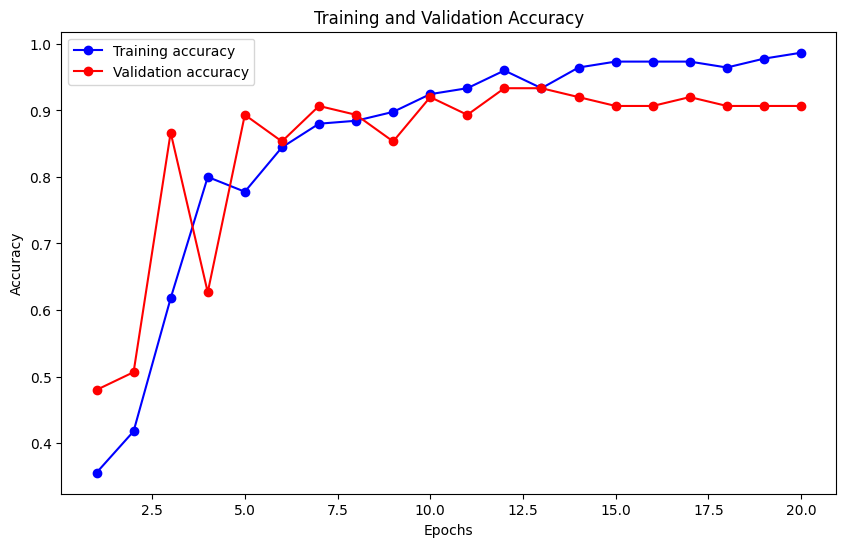

In [41]:
import matplotlib.pyplot as plt

# Extract accuracy and val_accuracy from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, 'bo-', label='Training accuracy')  # bo- for blue dot markers
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')  # ro- for red dot markers
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

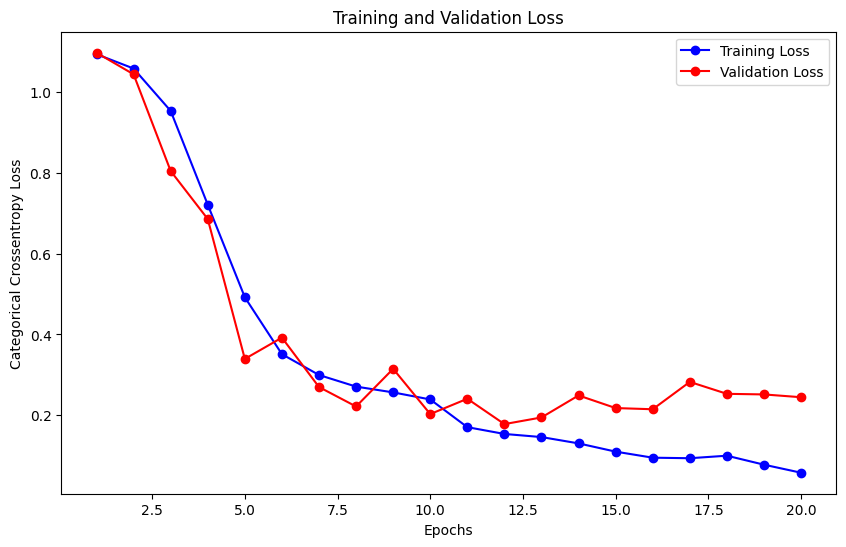

In [42]:
import matplotlib.pyplot as plt

# Extract accuracy and val_accuracy from the history object
acc = history.history['loss']
val_acc = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, 'bo-', label='Training Loss')  # bo- for blue dot markers
plt.plot(epochs, val_acc, 'ro-', label='Validation Loss')  # ro- for red dot markers
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.legend()

plt.show()


### New Model

In [3]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Flatten
from keras.optimizers import Adam, SGD
from keras import regularizers
from keras import preprocessing
from keras.layers import RandomFlip, RandomTranslation

def create_model(data_augmentation=None,
                 use_dropout=False,
                 use_batchnorm=False,
                 initialization='glorot_uniform',
                 optimizer = 'adam',
                 learning_rate=3e-4):

    model = Sequential()

    # Optionally add data augmentation
    if data_augmentation:
        model.add(data_augmentation)

    # Convolutional Block 1
    model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer=initialization, input_shape=(140, 61, 1)))
    if use_batchnorm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    if use_dropout:
        model.add(tf.keras.layers.Dropout(0.2))

    # Convolutional Block 2
    model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
    if use_batchnorm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(3, kernel_initializer=initialization))
    model.add(Activation('softmax'))

    # Define Optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model


In [4]:
# Default Data Augmentation - # By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation_default = keras.Sequential(
    [
        RandomFlip("horizontal"), #horizontal is a left-right flip
        #preprocessing.RandomZoom(0)
    ]
)
# Less Aggressive Data Augmentation
data_augmentation_shift = keras.Sequential([
    RandomFlip("horizontal"), #horizontal is a left-right flip
    RandomTranslation(height_factor=0.0, width_factor=0.2),
])



In [5]:
model_data_aug = create_model(data_augmentation_shift, use_dropout=True, use_batchnorm=True, initialization='glorot_uniform', optimizer='adam', learning_rate=3e-4)
model_data_aug.build((None, 140, 61, 1))  # Build the model
model_data_aug.summary()

c:\Users\berkb\anaconda3\envs\keras_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 140, 61, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 140, 61, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 140, 61, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 140, 61, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 70, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 70, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 70, 31, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 70, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 70, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 69440)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │       208,323 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,315 (833.26 KB)

 Trainable params: 213,219 (832.89 KB)

 Non-trainable params: 96 (384.00 B)

In [6]:
checkpoint_filepath = '/model/checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
history_1 = model_data_aug.fit(X_train, y_train, epochs=60, validation_data=(X_test, y_test), batch_size=32, callbacks=[model_checkpoint_callback])
keras.models.load_model(checkpoint_filepath)
model_data_aug.save('model/my_model.keras')

Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.3795 - loss: 1.9402 - val_accuracy: 0.4533 - val_loss: 7.4825
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6334 - loss: 1.0158 - val_accuracy: 0.4400 - val_loss: 7.5860
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7043 - loss: 0.7516 - val_accuracy: 0.7067 - val_loss: 1.7569
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.8036 - loss: 0.6264 - val_accuracy: 0.6800 - val_loss: 1.8854
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.8670 - loss: 0.4448 - val_accuracy: 0.8800 - val_loss: 1.3793
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8792 - loss: 0.3066 - val_accuracy: 0.9333 - val_loss: 1.3787
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8990 - loss: 0.3202 - val_accuracy: 0.7467 - val_loss: 1.8771
Epoch 8/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8356 - loss: 0.5345 - val_accuracy: 0.9333 - val_loss: 0.9955

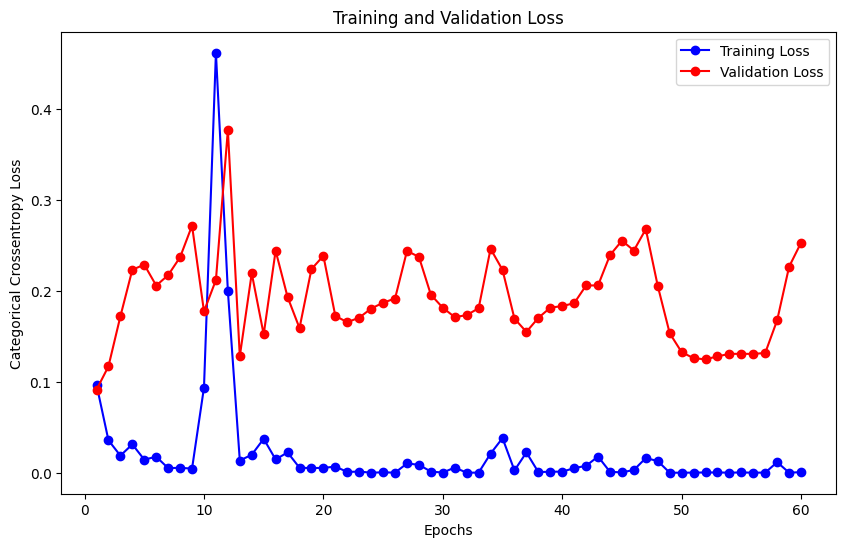

In [45]:
import matplotlib.pyplot as plt

# Extract accuracy and val_accuracy from the history object
acc = history_1.history['loss']
val_acc = history_1.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, 'bo-', label='Training Loss')  # bo- for blue dot markers
plt.plot(epochs, val_acc, 'ro-', label='Validation Loss')  # ro- for red dot markers
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.legend()

plt.show()


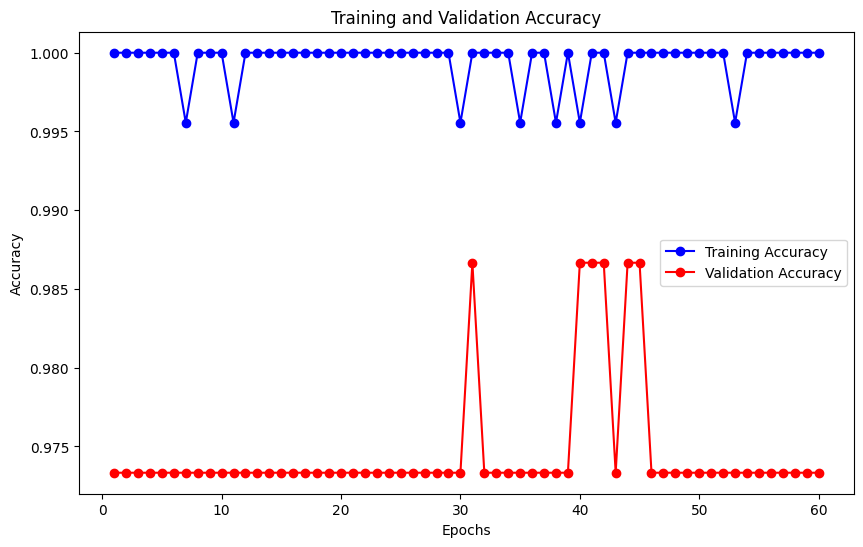

In [48]:
import matplotlib.pyplot as plt

# Extract accuracy and val_accuracy from the history object
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')  # bo- for blue dot markers
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')  # ro- for red dot markers
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### Export Trained Model to use in Arduino

In [56]:
import tensorflow as tf
import os

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model_simple)
tflite_model = converter.convert()

# Directory where to save the model
model_dir = 'model'

# Check if the directory exists, and if not, create it
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Path to the model file
model_path = os.path.join(model_dir, "model_simple.tflite")

# Save the converted model to file
with open(model_path, "wb") as f:
    f.write(tflite_model)
    
#For Windows open a Bash terminal in the root directory (same level as the "arduino" and "python" directories)
# and run the following command to convert the model to a C array:
# xxd -i python/model/model_simple.tflite > arduino/sensor_data/model_data.cc

INFO:tensorflow:Assets written to: C:\Users\rotas\AppData\Local\Temp\tmpk3s2b490\assets


INFO:tensorflow:Assets written to: C:\Users\rotas\AppData\Local\Temp\tmpk3s2b490\assets
'xxd' is not recognized as an internal or external command,
operable program or batch file.


### Test Model on PC

In [1]:
import serial
import os
import re

obj_name = 'name'
def find_highest_data_number(folder_path, prefix):
    # Regex pattern to match files starting with 'cap' followed by numbers
    pattern = re.compile(rf'^{re.escape(prefix)}(\d+)\.txt$')

    highest_number = -1
    for filename in os.listdir(folder_path):
        match = pattern.match(filename)
        if match:
            # Extract number part and convert to integer
            number = int(match.group(1))
            if number > highest_number:
                highest_number = number

    return highest_number if highest_number != -1 else 0

# Parameters
serial_port = 'COM9'  # Change this to your serial port name
baud_rate = 9600  
ser = serial.Serial(serial_port, baud_rate)

# Open serial port
max_vert_angle = 1000
min_vert_angle = 720
increment = 2
hor_multiplier = 1
vert_distance = max_vert_angle-min_vert_angle+1

image = [[0]*(60*hor_multiplier+1) for _ in range(int(vert_distance/increment))]
pos = None

# print(image)
pos = -1
start = False
# while(pos<60)

def getpos():
    line = ser.readline().decode('utf-8').strip()
    if 'POS' in line:
        # Extract the part of the string after 'POS'
        pos_value_str = line.split('POS')[-1].strip()
        try:
            # Attempt to convert the following value to an integer
            pos_value = int(pos_value_str)
            # print("POS Value:", pos_value)
            return int(pos_value_str)
        except ValueError:
            # Handle the case where conversion fails
            print("Could not convert POS value to an integer:", pos_value_str)
            return None

ser.write(b'S')
print('S')


pos_value_str = getpos()

while True:
    pos_value = getpos()

    if pos_value!=None:
        print(pos_value)
        if pos_value == min_vert_angle+increment:
            break
print('Started SCAN')
while(pos_value<max_vert_angle):
    line = ser.readline().decode('utf-8').strip()

    if 'POS' in line:
        # Extract the part of the string after 'POS'
        pos_value_str = line.split('POS')[-1].strip()
        try:
            # Attempt to convert the following value to an integer
            pos_value = int(pos_value_str)
            print("POS Value:", pos_value)
        except ValueError:
            # Handle the case where conversion fails
            print("Could not convert POS value to an integer:", pos_value_str)
    elif(pos_value!=None):
        print('here')
        if "Angle" in line:
            parts = line.split(":")
            if len(parts) == 2:
                angle, value = parts
                angle = int(angle.split()[1])  # Extract angle number
                value = int(value.strip())  # Extract value
                if 1 <= angle <= (60*hor_multiplier):
                    print('angle',angle)
                    print('pos',pos_value)

                    image[int((pos_value-min_vert_angle)/increment)][angle]=value
                    print(f"Stored value {value} at angle {angle}")

test_image = np.array(image)
array = np.array(image)

# Clip values above 1000 to 1000
clipped_array = np.clip(array, None, 1000)

flipped_array = np.flipud(clipped_array)

# Display the array as an image
plt.imshow(flipped_array, cmap='gray', interpolation='nearest')
plt.colorbar()  # Optional: adds a color bar to indicate the scale
plt.show()

ser.close()

SerialException: could not open port 'COM5': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)

In [17]:
def get_original_labels(output, label_encoder):
    # Convert the categorical data back to integers
    y_integers_predicted = np.argmax(output, axis=1)

    # Use the inverse_transform method of the label encoder to get the original labels
    y_labels_predicted = label_encoder.inverse_transform(y_integers_predicted)

    return y_labels_predicted

In [46]:
import os

 
# Directory where the data files are stored
test_folder = '../predict'
#test_image = read_file(file_path)
test_image = test_image.reshape(-1, 140, 61, 1)
# test_image = np.array(test_image)
output = model_data_aug.predict(test_image)
# output = model_data_aug.predict(test_image)
# get_model().predict(test_image)
print(output)
original_labels = get_original_labels(output, label_encoder)
print(original_labels)
test_file = f"{original_labels}.txt"
file_path = os.path.join(test_folder, test_file)
with open(file_path, 'w') as file:
    for element in image:
        file.write(f"{element}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[[1.0000000e+00 8.7346706e-17 1.9813228e-24]]
['Bottle']
